## Customer Churn Prediction 
by Ori Rosenthal

### Introduction:<br>
Customer retention is one of the key aspects of <b>C</b>ustomer <b>R</b>elationship <b>M</b>anagement. 


Customer churn (aka, customer attrition, customer turnover, or customer defection) is the loss of clients or customers,<br>
and, customer churn rate, is the percentage of customers who have stopped using your company's product or service during a certain period of time.

Managing client churn is a major challenge facing companies, particularly those offering subscription-based services.

The goal is to predict customer churn using Machine Learning model. <br>Such models will create a list of customers that are most susceptible to churn, so that they can be given priority to a targeted customer retention plan.

This case study modeling based on telco-customer-churn dataset from Kaggle, with over 7000 customers (rows), and each column contains customer’s attributes (features).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve,precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score,recall_score,accuracy_score, plot_roc_curve, cohen_kappa_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import eli5
pd.options.mode.chained_assignment = None
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Visualization

def churnratio():
    
    val = df["Churn"].value_counts().values.tolist()

    trace = go.Pie(labels = ["Not Churned","Churned"] ,
                   values = val ,
                   marker = dict(colors =  [ "#34495e" ,'#e74c3c']), hole = .5, textfont_size=20)
    layout = go.Layout(dict(title = "Train Dataset Customers"))
    data = [trace]
    fig = go.Figure(data = data,layout = layout)
    py.iplot(fig)

def report(y_true, y_pred):
    print("Accuracy = " , accuracy_score(y_true, y_pred).round(3))
    print("Precision = " ,precision_score(y_true, y_pred).round(3))
    print("Recall = " ,recall_score(y_true, y_pred).round(3))
    print("F1 Score = " ,f1_score(y_true, y_pred).round(3))
    print("Cohen kappa = " ,cohen_kappa_score(y_true, y_pred).round(3))

In [3]:
# Import dataset 

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Let's look at the first 5 rows

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print(f'Dataset contains {df.shape[0]} rows, and {df.shape[1]} columns.')

Dataset contains 7043 rows, and 21 columns.


## Content
#### Each row represents a customer, each column contains customer’s attributes.

The data set includes information about:

* Customers who left within the last month – the column is called <b>Churn</b>.<br>
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.<br>
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges.<br>
* Demographic info about customers – gender, age range, and if they have partners and dependents.

In [6]:
# Inspect all the features data types and missing values
pd.concat([df.dtypes,df.isna().sum(),df.nunique()],axis=1).rename(columns={0: "Types", 1: "Nulls", 2:'Nunique'})

,Types,Nulls,Nunique
customerID,object,0,7043
gender,object,0,2
SeniorCitizen,int64,0,2
Partner,object,0,2
Dependents,object,0,2
tenure,int64,0,73
PhoneService,object,0,2
MultipleLines,object,0,3
InternetService,object,0,3
OnlineSecurity,object,0,3


In [7]:
df.drop('customerID', axis=1, inplace=True)
# Replace spaces with null values in column of total charges
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan).astype(float)
print(f'TotalCharges number of Nan values: {df["TotalCharges"].isna().sum()}')
print(f'TotalCharges percentage of Nan values: {np.round(df["TotalCharges"].isna().sum()/len(df)*100,3)}%')


TotalCharges number of Nan values: 11
TotalCharges percentage of Nan values: 0.156%


In [8]:
# Fill misiing values with midian
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [9]:
# Describe statistis for numerical features
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.16,0.37,0.00,0.00,0.00,0.00,1.00
tenure,7043.0,32.37,24.56,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.76,30.09,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2281.92,2265.27,18.80,402.22,1397.48,3786.60,8684.80


## Let's explore our dataset

In [10]:
churnratio()

26.5% churn rate 

We'll start with the <b>numerical features</b>, and look at the distribution for those who've been churned, and for those who haven't.

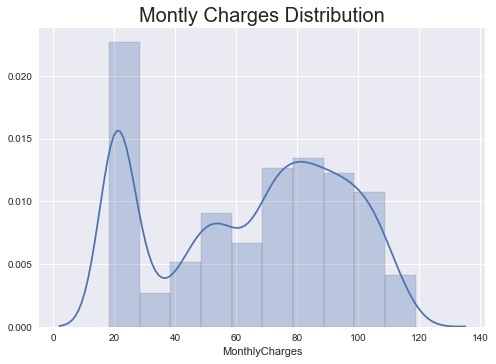

In [11]:
plt.style.use('seaborn')
plt.title("Montly Charges Distribution",size=20)
sns.distplot(df['MonthlyCharges'],bins=10,hist_kws={'edgecolor':'black','alpha':.3});

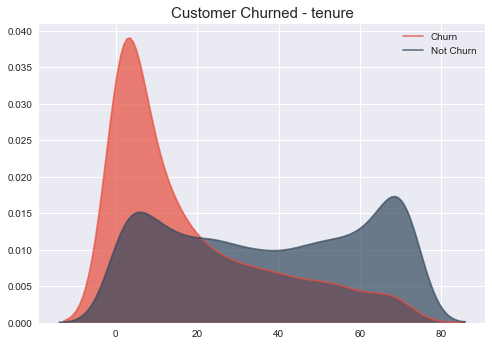

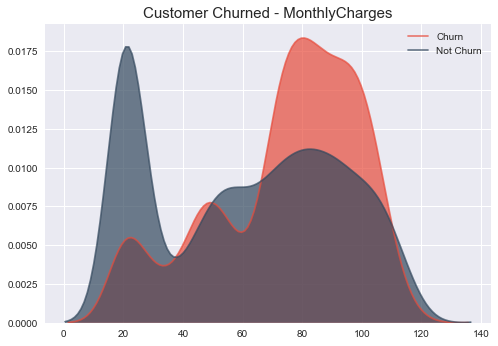

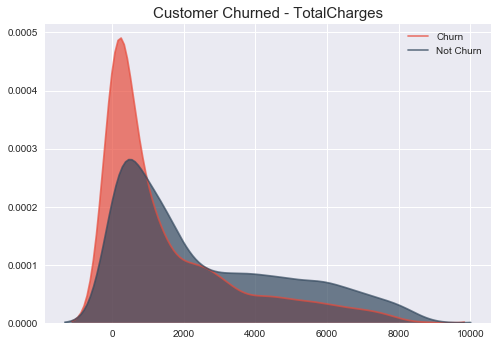

In [12]:
for i in ('tenure','MonthlyCharges', 'TotalCharges'):
    
    sns.kdeplot(df[df['Churn']=='Yes'][str(i)], color="#e74c3c", shade=True, label = 'Churn', alpha=0.7)
    sns.kdeplot(df[df['Churn']== 'No'][str(i)], color="#34495e", shade=True, label = 'Not Churn', alpha=0.7)
    plt.title(f'Customer Churned - {i}', size=15)
    plt.show()

 We can already see from those plots that:
* Recent customers will be more likely to churn
* Customers with higher monthly charges often have a greater risk of churning


### Now, let 's explore the categorical features and their relationship to our variable target.

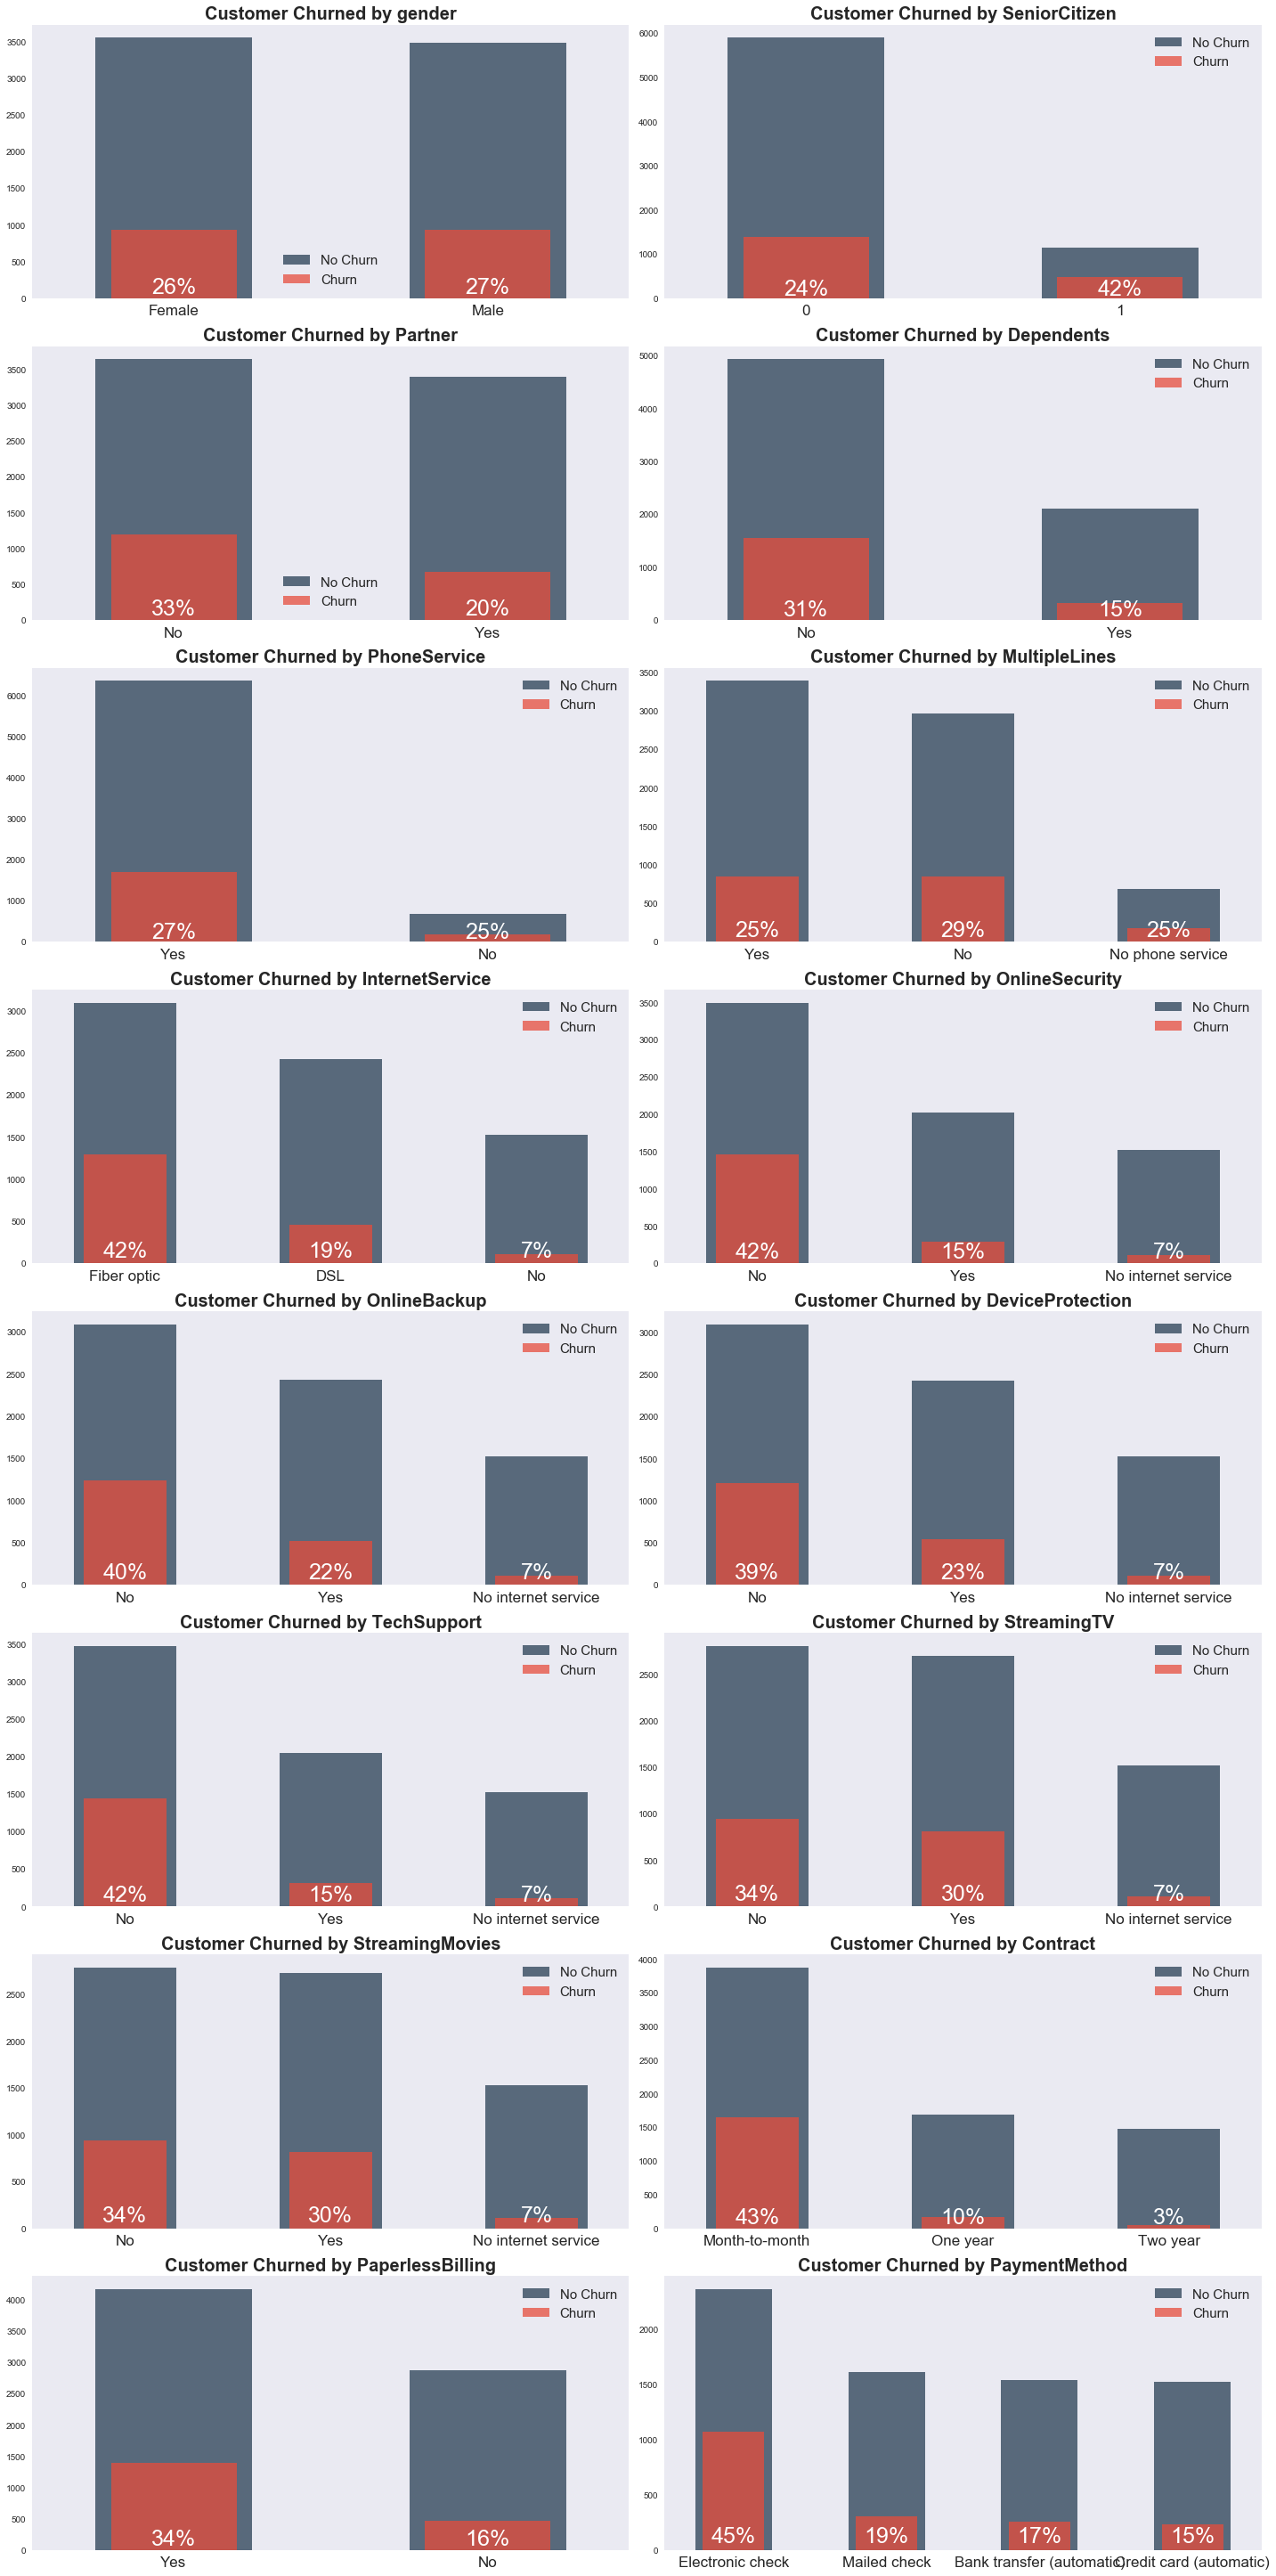

In [13]:
# countplot for each category + churn perecetage 
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize = (20, 50))

for n, i in enumerate(df.columns[df.nunique() <5].drop('Churn')):
    
    ax = plt.subplot(10, 2, n+1)
    no = df[i].value_counts().plot(kind='bar', ax=ax,width=.5,  color="#34495e", alpha=0.8)
    plt.title(f'Customer Churned by {i}', fontweight='bold',size=20)
    churn = df[df.Churn=='Yes'][i].value_counts().plot(kind='bar',ax=ax, width=.4, color="#e74c3c", alpha=0.75)
    plt.xticks(rotation=0,fontsize=17);
    plt.legend(['No Churn', 'Churn'],fontsize= 15)
    fig.subplots_adjust(hspace=0.3)
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]
    
    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l
        ax.text(right.get_x() + right.get_width()/2, 70,
                '{0:.0%}'.format(height_r/(total)), ha="center", fontsize=25, color='w')
    
    plt.xlabel(""); 
    plt.tight_layout();


<b><u>To summarize the categorical features, we can see that</u>:</b>


* There is no impact on Churn by gender.
* SeniorCitizens have a greater degree of churn.
* Customers without partner have higher churn rate as well costumers without dependents.
* Customers with Fiber optic internet service are more probable to churn than others.
* Costumers without online security, back-up and device protection are more likely to churn.
* No technical support can be a churn indicator.
* Short-term contracts are subject to higher churn rates.
* Customers with paperless billing are more likely to churn.
* As far as payment methods, the electronic check has a very high churn rate.



###  Let's look at Correlation between the features

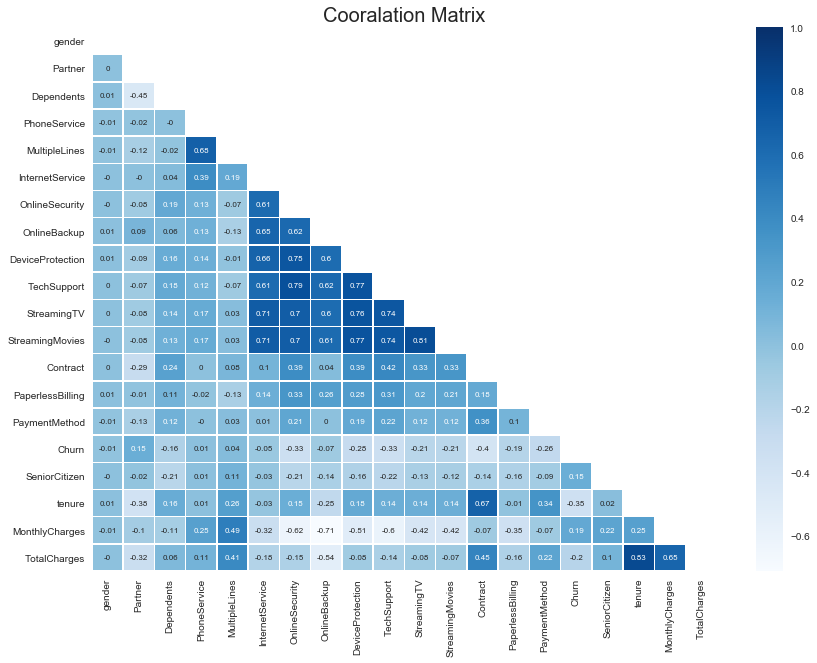

In [14]:
# In order to get all the correlation between the features, I first factorized the features of the object type,
# and then I joined the numerical data types.
corr = (df.select_dtypes(include='object').apply(lambda x: pd.factorize(x)[0])\
       .join(df.select_dtypes(include=['float','int64']))).corr().round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr,mask=mask, cmap='Blues',annot=True,annot_kws={"size":8},linewidths=0.5);
    sns.set(font_scale=1.5);
    plt.title('Cooralation Matrix', size=20);

We see that there is a high correlation between the additional services,<br>that is, if someone is already adding one service then the likelihood of adding more services is high.

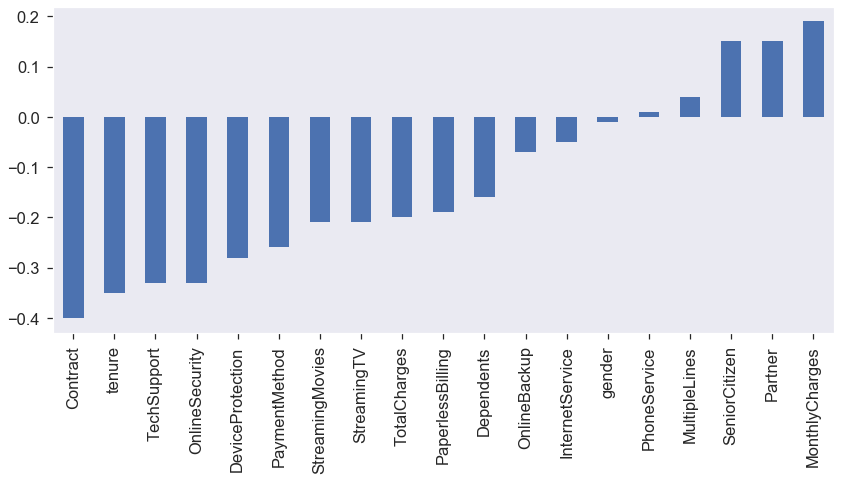

In [15]:
# Correlation of Churn with other variables
corr['Churn'].drop('Churn').sort_values().plot(kind='bar', figsize=(14,6));

<b><u>Data preprocessing</u></b>

In [16]:
binary_categories=[]
for col in df.columns:
    if df[col].isin(['Yes']).any():
        binary_categories.append(col)
        print(col)

Partner
Dependents
PhoneService
MultipleLines
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
PaperlessBilling
Churn


In [17]:
binary_categories_dic = {'Yes': 1,
                         'No': 0,
                         'No internet service': 0,
                         'No phone service': 0}

In [18]:
for col in binary_categories:
    df[col] = df[col].map(binary_categories_dic)

In [19]:
# ordering columns by dtypes
df = df[df.dtypes.sort_values().index.tolist()]

In [20]:
# grouping features by type (numerical, categorical)
num_features = ['tenure','MonthlyCharges', 'TotalCharges']
cat_features = df.select_dtypes(include='object').columns.tolist()
name_num_features = df.drop(['Churn'], axis=1).select_dtypes(include=['int64','float']).columns.tolist()


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OnlineBackup      7043 non-null   int64  
 1   PaperlessBilling  7043 non-null   int64  
 2   StreamingMovies   7043 non-null   int64  
 3   StreamingTV       7043 non-null   int64  
 4   TechSupport       7043 non-null   int64  
 5   DeviceProtection  7043 non-null   int64  
 6   OnlineSecurity    7043 non-null   int64  
 7   Churn             7043 non-null   int64  
 8   MultipleLines     7043 non-null   int64  
 9   PhoneService      7043 non-null   int64  
 10  tenure            7043 non-null   int64  
 11  Dependents        7043 non-null   int64  
 12  Partner           7043 non-null   int64  
 13  SeniorCitizen     7043 non-null   int64  
 14  TotalCharges      7043 non-null   float64
 15  MonthlyCharges    7043 non-null   float64
 16  Contract          7043 non-null   object 


In [22]:
# stepes for pipeline transformation
column_trans = make_column_transformer(
                (StandardScaler(), num_features),
                (OneHotEncoder(), cat_features),
                 remainder='passthrough')

In [23]:
# Splitting the data-set into independent (Churn) and dependent features

X = df.drop('Churn', axis=1)
y = df.Churn.values

# Split the dataset into train (60%), validate(20%), test (20%)
# We'll use stratify parameter to ensure the proportion of the class labels in each subset is the same.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=12)
print(f'training set: {X_train.shape[0]}')
print(f'validation set: {X_val.shape[0]}')
print(f'testing set: {X_test.shape[0]}')

training set: 4225
validation set: 1409
testing set: 1409


In [24]:
X_train.dtypes

OnlineBackup          int64
PaperlessBilling      int64
StreamingMovies       int64
StreamingTV           int64
TechSupport           int64
DeviceProtection      int64
OnlineSecurity        int64
MultipleLines         int64
PhoneService          int64
tenure                int64
Dependents            int64
Partner               int64
SeniorCitizen         int64
TotalCharges        float64
MonthlyCharges      float64
Contract             object
PaymentMethod        object
InternetService      object
gender               object
dtype: object

In [25]:
res_features = num_features
pass_features = [e for e in name_num_features if e not in num_features]
pipe = Pipeline([('ct', column_trans), ('classifier', LogisticRegression())]).fit(X_test, y_test)
exp_features = res_features+list(pipe.named_steps['ct'].named_transformers_['onehotencoder']\
                                 .get_feature_names(cat_features)) + pass_features

# Creating a parallel dateset for later exploration and feature selection 
sm = SMOTE(random_state=4)
X_train_res = column_trans.fit_transform(X_train)
X_train_smote, y_train_smote = sm.fit_sample(X_train_res, y_train)
X_train_smote = pd.DataFrame(X_train_smote, columns = exp_features)

### Models

Now, we are going to make a comparison between various methods of machine learning.<br>
First, we'll create a dictionary of models with default setting, and one for training and predicting on val set<br>
Next, loop over each model while:<br>
* Making a pipeline for preprocessing the training data each time with SMOTE.<br>
* Evaluation by cross-validation (5 folds) on various performance metrics.<br>
* building a new dataframe for the results.
* Compare the results and visualize the ROC curves and the Confusion matrices for each of them.
* Randomized search on hyper parameters for evrey model with refit using the best f1 score found
* Choose 2 of our best models based on the relevant business matrices.
* Tuning threshold for better results.
* Test the models with unseen data (testing set).

<u>Note</u>: We cross validate only on the training subsets (X_train_smote, y_train_smote),<br>
so essentially we take each time a proportion of the training data to validate our model,<br>
using the pipeline also protects us from data leakage.



In [26]:
# Creating ML-models dictionary (with default setting)

models={
    'LogReg'            : LogisticRegression(max_iter=2000),
    'DecisionTree'      : DecisionTreeClassifier(),
    'RandomForest'      : RandomForestClassifier(),
    'SVM'               : SVC(probability=True),
    'KNN'               : KNeighborsClassifier(),
    'AdaBoost'          : AdaBoostClassifier(),
    'XGBoost'           : XGBClassifier(),
    'LightGBM'          : LGBMClassifier(),
    
}


# Cross validation on train data

df_metrics=pd.DataFrame([])
predicts={}

for model_name in models.keys():
    
    metrics={}
    pipe = Pipeline([('ct', column_trans), ('sm', SMOTE(random_state=12)), ('classifier', models[model_name])])
    pred = pipe.fit(X_train, y_train)
    predicts[model_name] = pred.predict(X_val)
    metrics['accuracy']= cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
    metrics['roc_auc'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    metrics['precision'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='precision').mean()
    metrics['recall'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='recall').mean()
    metrics['f1'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
    df_metrics=pd.concat([df_metrics,pd.DataFrame(metrics,index=[model_name]).T],axis=1)
    


df_metrics.T.style.highlight_max(color='lightgreen').set_precision(3)

,accuracy,roc_auc,precision,recall,f1
LogReg,0.746,0.839,0.514,0.791,0.623
DecisionTree,0.714,0.654,0.464,0.518,0.484
RandomForest,0.770,0.812,0.570,0.571,0.573
SVM,0.756,0.817,0.529,0.723,0.611
KNN,0.686,0.755,0.445,0.731,0.553
AdaBoost,0.768,0.840,0.547,0.732,0.626
XGBoost,0.779,0.835,0.572,0.669,0.617
LightGBM,0.776,0.822,0.579,0.575,0.576


According to the results of Cross Validation, it can be seen that LogReg and AdaBoost had the best relevant scores (f1, roc_auc).<br>
It is important to note that the results above are with the default parameters of each and every model and in a short time we will check the models again, after adjusting the hyperparameters with a RandomizedSearchCV.

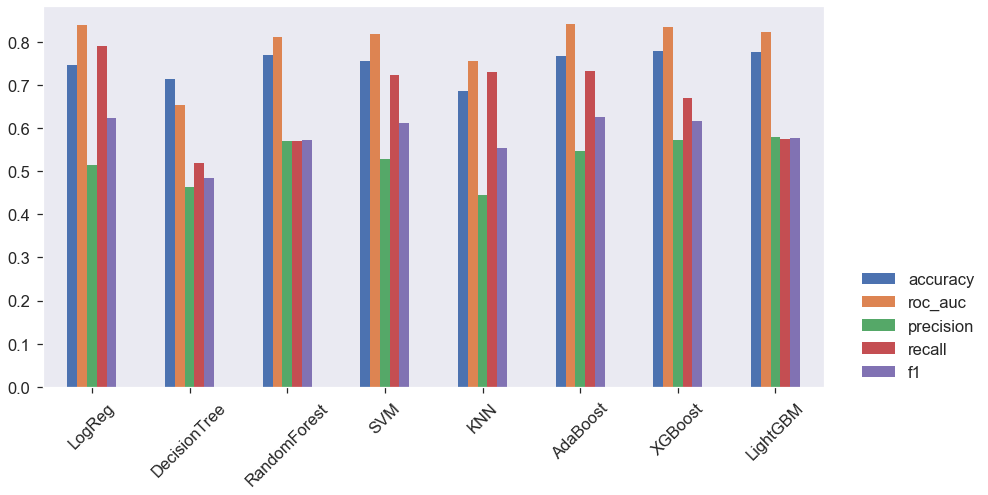

In [27]:
df_metrics.T.plot(kind='bar', figsize=(14,7));
plt.legend(loc=(1.04,0)); plt.xticks(rotation=45);

<b>Comparing ROC Curves derived From our models on validation sets</b>

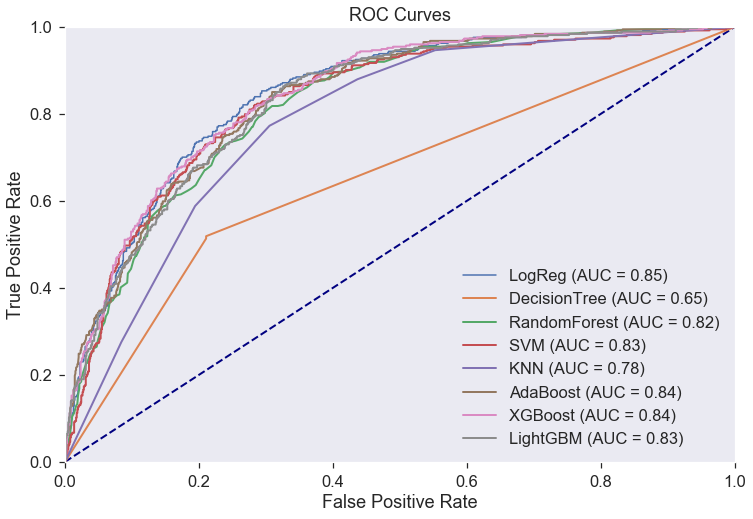

In [28]:
# Compare how well each algorithm used to identify true positive (sensitivity) vs. false positive (specificity).

model_test = {}
fig, ax = plt.subplots(figsize=(12,8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.title('ROC Curves'); ax.margins(0,0)

for n, model_name in enumerate(models.keys()):
  
    pipe = Pipeline([('ct', column_trans), ('sm', SMOTE(random_state=12)), ('classifier', models[model_name])])
    model_test[model_name] = pipe.fit(X_train, y_train)
    if n == 0:
        disp = plot_roc_curve(model_test[model_name], X_val,  y_val, name=model_name, ax=ax)
    else:
        plot_roc_curve(model_test[model_name], X_val, y_val, name=model_name, ax=disp.ax_, lw=2) 

roc_auc (the area under the ROC curve) evaluates the ability of the method to classify correctly,
and the classifier with the highest AUC score will be considered better.

<b>Comparing confusion matrices (validation set) derived from our models</b>

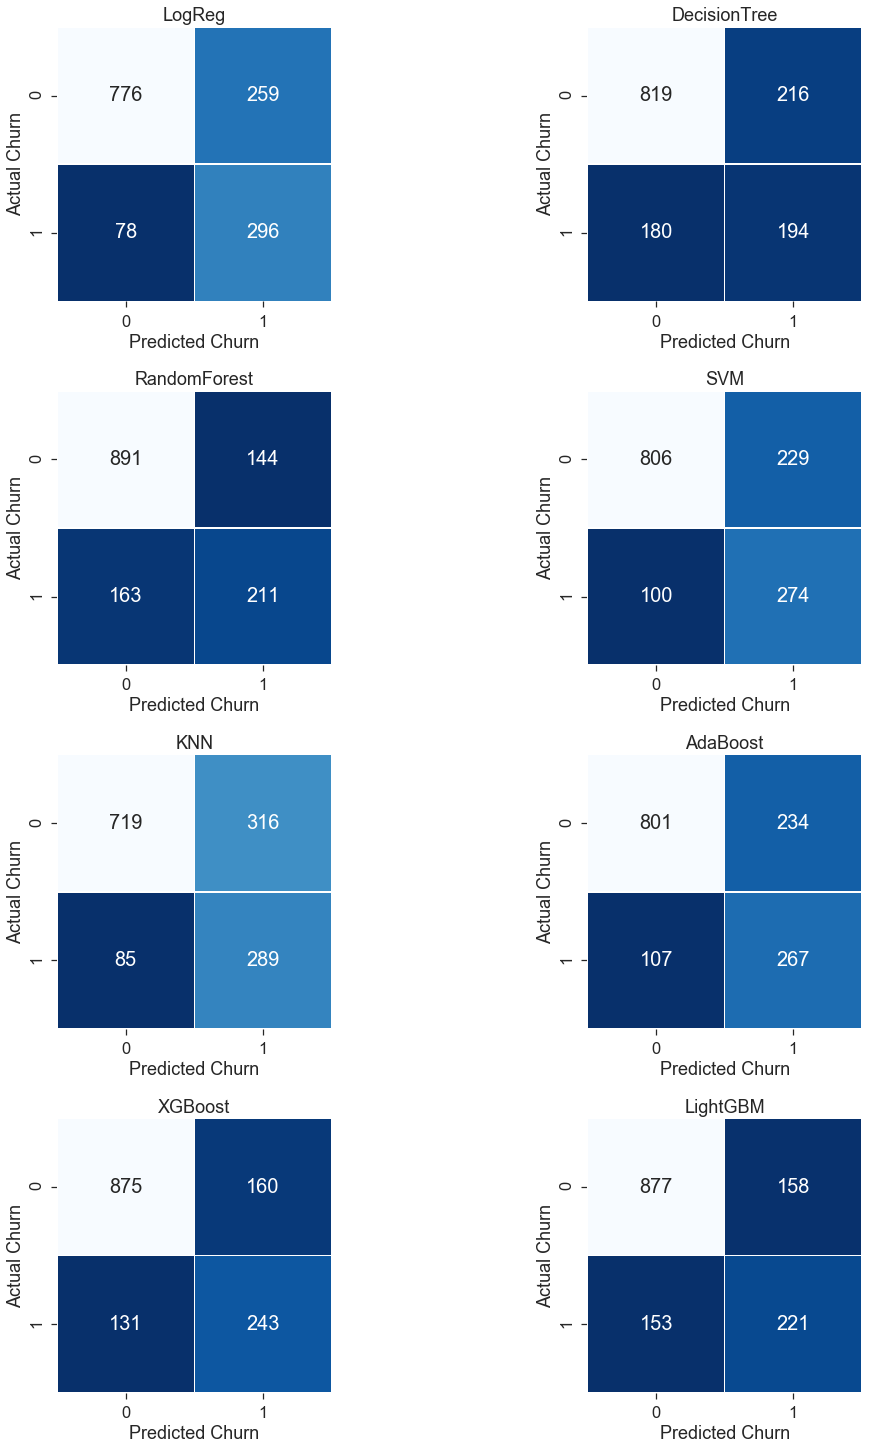

In [29]:
plt.subplots(figsize = (15, 40))

for n, model in enumerate(models.keys()):
    
    plt.subplot(8, 2, n+1)
    cm = confusion_matrix(y_val, predicts[model])
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,
            cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":20});
    plt.title(model)
    plt.ylabel('Actual Churn');
    plt.xlabel('Predicted Churn');
    plt.tight_layout()   

In [30]:
# Build a dictionary with the keys being the hyperparameters for evrey ML algorithm
search_parms = dict()

search_parms['LogReg'] =            {'classifier__C': [0.1, 0.5, 0.75, 1, 10],
                                    'classifier__solver':['lbfgs','saga']}


search_parms['DecisionTree'] =     {
                                    'classifier__max_depth':[3,6,10,15,25,30,None],
                                    'classifier__min_samples_leaf':[1,2,5,10,15,30],
                                    'classifier__max_leaf_nodes': [2, 5,10]}

search_parms['RandomForest'] =     {
                                    'classifier__n_estimators': [10, 100, 1000],
                                    'classifier__max_depth':[5,8,15,25,30,None],
                                    'classifier__min_samples_leaf':[1,2,5,10,15,30],
                                    'classifier__max_leaf_nodes': [2, 5,10]}

search_parms['SVM'] =              {
                                   'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                                   'classifier__gamma': [1,0.1,0.01,0.001],
                                   'classifier__kernel': ['rbf', 'poly', 'sigmoid']}

search_parms['KNN'] =              {
                                    'classifier__n_neighbors':[4,5,6,7,8,9,10],
                                    'classifier__leaf_size':[1,2,3,5],
                                    'classifier__weights':['uniform', 'distance'],
                                    'classifier__algorithm':['auto', 'ball_tree','kd_tree','brute']}


search_parms['AdaBoost'] =         {
                                    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
                                    'classifier__n_estimators': [50, 75, 100, 200, 300, 500]}


search_parms['XGBoost'] =          {
                                   'classifier__min_child_weight': [1, 5, 10],
                                   'classifier__gamma': [0.5, 1, 1.5, 2, 5],
                                   'classifier__subsample': [0.6, 0.8, 1.0],
                                   'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                                   'classifier__max_depth': [3, 4, 5]}

search_parms['LightGBM'] =         {
                                   'classifier__max_depth': [25,50, 75],
                                   'classifier__learning_rate' : [0.01,0.05,0.1],
                                   'classifier__num_leaves': [300,900,1200],
                                   'classifier__n_estimators': [200]}



<b>Randomized search on hyper parameters for evrey model with refit using the best RocAuc score found.</b> 

In [31]:
# Creating scores metrics dictionary

scorers = {
            'accuracy': 'accuracy',
            'AUC':      'roc_auc',
            'Recall':   'recall',
            'precision':'precision',
            'f1':        'f1'}


df_metrics_gs=pd.DataFrame([])
predicts={}
b_parms={}

for model_name in models.keys():

    metrics={}
    pipe =                Pipeline([('ct', column_trans), ('sm', SMOTE(random_state=12)), ('classifier', models[model_name])])
    predicts[model_name] = RandomizedSearchCV(pipe, search_parms[model_name],cv=5,scoring=scorers,
                                              refit='AUC', random_state=42).fit(X_train, y_train)
    metrics['accuracy']  = predicts[model_name].cv_results_['mean_test_accuracy'].mean()
    metrics['precision'] = predicts[model_name].cv_results_['mean_test_precision'].mean()
    metrics['recall']    = predicts[model_name].cv_results_['mean_test_Recall'].mean()
    metrics['roc_auc']   = predicts[model_name].cv_results_['mean_test_AUC'].mean() 
    metrics['f1']        = predicts[model_name].cv_results_['mean_test_f1'].mean()
    b_parms[model_name]  = predicts[model_name].best_params_ 
    df_metrics_gs =        pd.concat([df_metrics_gs,pd.DataFrame(metrics,index=[model_name]).T],axis=1)



df_metrics_gs.T.style.highlight_max(color='lightgreen').set_precision(3)

,accuracy,precision,recall,roc_auc,f1
LogReg,0.746,0.514,0.789,0.839,0.622
DecisionTree,0.699,0.469,0.811,0.771,0.589
RandomForest,0.724,0.491,0.802,0.823,0.607
SVM,0.593,0.434,0.656,0.758,0.445
KNN,0.697,0.454,0.692,0.759,0.548
AdaBoost,0.747,0.521,0.776,0.837,0.621
XGBoost,0.781,0.577,0.651,0.835,0.612
LightGBM,0.765,0.559,0.551,0.808,0.554


In [32]:
# Ranked Models after RandomsearchCV based on roc_auc and f1 score
df_metrics_gs.T[['roc_auc', 'f1']].round(3).rank(pct=True).sum(axis=1).sort_values(ascending=False)

LogReg          2.000
AdaBoost        1.750
XGBoost         1.500
RandomForest    1.250
LightGBM        0.875
DecisionTree    0.875
KNN             0.500
SVM             0.250
dtype: float64

Having regard to the results of the auc score as well as the comparison of other metrics,<br>
we opt to proceed with <b><u>AdaBoost</u></b> and <b><u>Logistic Regression</u></b> models.

To maximize the performance of the models for our goal, let's first <b>explore</b> them, <b>tune</b> some hyperparameters,<br>
    and then <b>test</b> our model on the test data (X_test).

In [33]:
# Results of the models chosen from the cross validation process.

top_models = df_metrics_gs.T.iloc[[0,5]].round(3)
top_models

,accuracy,precision,recall,roc_auc,f1
LogReg,0.746,0.514,0.789,0.839,0.622
AdaBoost,0.747,0.521,0.776,0.837,0.621


Our main objective is to predict whether a customer is going to churn,<br>
and the recall score is one of the moset relevent for that purpose.<br>
0.749 recall score, for AdaBoost model, means that for every 100 costumers that churn we're predicting 75 of them.<br>
Now, there's a trade-off between Recall (tp/(tp+fn) and Precision (tp/(tp+fp), means increasing one parameter leads to decreasing of the other.<br>
In our case (AdaBoost) high recall comes with low-precision, which means that for every 100 costumers that we predict as possibly churn,<br> only 54 of them will eventually be churned.<br>


<b>Feature selection</b>

In [34]:
# Let's sort all the features by correlation to the target
corr_features= abs(X_train_smote.corrwith(pd.DataFrame(y_train_smote)[0])).sort_values(ascending=False)
corr_features_to_test_var = corr_features.index.tolist()
corr_features.head()

Contract_Month-to-month           0.489434
tenure                            0.426139
Contract_Two year                 0.396757
InternetService_Fiber optic       0.357830
PaymentMethod_Electronic check    0.331846
dtype: float64

Model name - best F1 score, Number of features
[('LogReg', 0.624, 26), ('AdaBoost', 0.631, 21)]


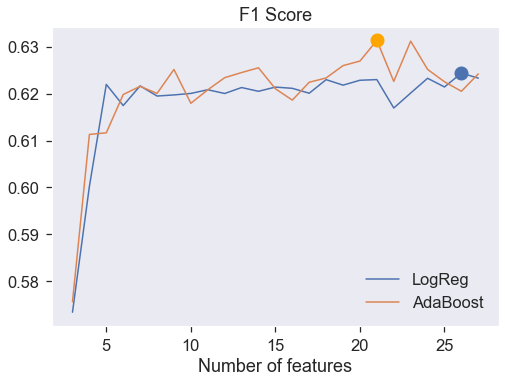

In [35]:
# loop from 3 to length of features list and add another feature each time
# cross-validate and store in a DataFrame

f1_results = pd.DataFrame(columns=top_models.index, index=np.arange(3,(len(corr_features))), dtype='int')

for n in range(3,len(corr_features_to_test_var)+1):
    X_train_f = pd.DataFrame(X_train_res, columns = exp_features)[corr_features_to_test_var[0:n]]
    
    for model in top_models.index:
        pipe = Pipeline([('sm', SMOTE(random_state=12)), ('classifier', models[model])])
        f1_results.loc[n,str(model)] = cross_val_score(pipe, X_train_f, y_train, cv=5, scoring='f1').mean()
        
print('Model name - best F1 score, Number of features')
print([(x, round(f1_results[x].max(),3), f1_results[x].idxmax()) for x in f1_results.columns])
f1_results.plot();
plt.title('F1 Score');plt.xlabel('Number of features');
plt.plot(f1_results.iloc[:,0].idxmax(), f1_results.iloc[:,0].max(), 'o', markersize=10,c="b", mew=4,)
plt.plot(f1_results.iloc[:,1].idxmax(), f1_results.iloc[:,1].max(), 'o', markersize=10, c="orange", mew=4);

<b>Hyperparameter Tuning (using our RandomizedSearchCV results dictionary), validation, testing results (unseen data - X_test) and,<br> feature Importance</b>

<b>AdaBoost</b>

In [36]:
# best hyperparameters after RandomizedSearchCV
print(b_parms['AdaBoost'])

{'classifier__n_estimators': 500, 'classifier__learning_rate': 0.1}


Test report on Validation set:
Accuracy =  0.774
Precision =  0.555
Recall =  0.738
F1 Score =  0.634
Cohen kappa =  0.475




Test report on Test set:
Accuracy =  0.784
Precision =  0.572
Recall =  0.743
F1 Score =  0.647
Cohen kappa =  0.495


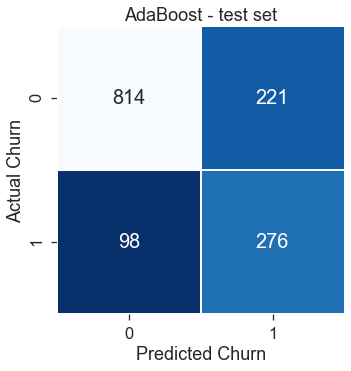

In [37]:
# changing hyperparamters model, and test on validation and test datasets

pipe_ada = Pipeline([('ct', column_trans), ('sm', SMOTE(random_state=12)),
                     ('classifier', AdaBoostClassifier(n_estimators = 500, learning_rate = 0.1))])
ada_clf = pipe_ada.fit(X_train, y_train)
clf_pred_val = ada_clf.predict(X_val)
clf_pred_test = ada_clf.predict(X_test)
print('Test report on Validation set:')
report(y_val, clf_pred_val)
print('\n')
print('\n\nTest report on Test set:')
report(y_test, clf_pred_test)
cm = confusion_matrix(y_val, clf_pred_val)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,
        cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":20});
plt.title('AdaBoost - test set')
plt.ylabel('Actual Churn');
plt.xlabel('Predicted Churn');
plt.tight_layout()   

AdaBoost model, Confusion matrix results for test data:
* 74% of churned customers predicted correctly (recall).
* 57% of the churn predictions are correct (precision).

Showing AdaBoost model weights for each feature, showing how influential it might have been to contribute to the final decision:

In [38]:
eli5.explain_weights(pipe_ada.named_steps['classifier'], top=25, feature_names =exp_features)

Weight,Feature
0.1620 ± 0.7369,PaperlessBilling
0.1400 ± 0.6940,Partner
0.1060 ± 0.6157,tenure
0.0900 ± 0.5724,TechSupport
0.0800 ± 0.5426,DeviceProtection
0.0700 ± 0.5103,SeniorCitizen
0.0660 ± 0.4966,OnlineBackup
0.0560 ± 0.4598,OnlineSecurity
0.0400 ± 0.3919,Dependents
0.0340 ± 0.3625,MonthlyCharges


<b>Logistic Regression</b>

In [39]:
# best hyperparameters after RandomizedSearchCV
b_parms['LogReg']

{'classifier__solver': 'saga', 'classifier__C': 0.5}

Test report on Validation set:
Accuracy =  0.762
Precision =  0.534
Recall =  0.791
F1 Score =  0.638
Cohen kappa =  0.47




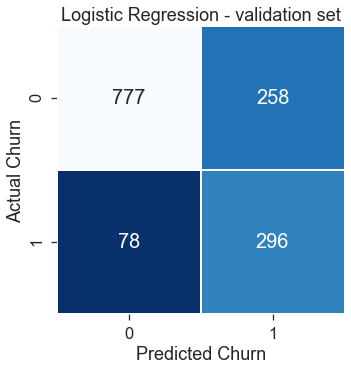

In [40]:
# Validation set 
pipe_lr =  Pipeline([('ct', column_trans), ('sm', SMOTE(random_state=12)),
                     ('classifier', LogisticRegression(solver = 'saga', C = 0.5, max_iter=2000))])
lr_clf = pipe_lr.fit(X_train, y_train)
clf_pred_val = lr_clf.predict(X_val)
clf_pred_test = lr_clf.predict(X_test)
print('Test report on Validation set:')
report(y_val, clf_pred_val)
print('\n')
# print('\n\nTest report on Test set:')
# report(y_test, clf_pred_test)
cm = confusion_matrix(y_val, clf_pred_val)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,
        cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":20});
plt.title('Logistic Regression - validation set')
plt.ylabel('Actual Churn');
plt.xlabel('Predicted Churn');
plt.tight_layout()   

Logitic Regresion model, Confusion matrix results for validation data:
* 79% of churned customers predicted correctly (recall).
* 53 of the churn predictions are correct (precision).

Showing Logistic Regression model weights for each feature, showing how influential it might have been to contribute to the final decision:

In [41]:
eli5.explain_weights(pipe_lr.named_steps['classifier'], top=50, feature_names = exp_features)

Weight?,Feature
+0.815,TotalCharges
+0.637,Contract_Month-to-month
+0.570,InternetService_Fiber optic
+0.426,PaperlessBilling
+0.348,StreamingMovies
+0.286,MultipleLines
+0.232,StreamingTV
+0.194,PaymentMethod_Electronic check
+0.088,MonthlyCharges
+0.074,SeniorCitizen


Let's explore our Logistic Regression model with the precision-recall curve that shows the tradeoff between precision and recall for different thresholds.

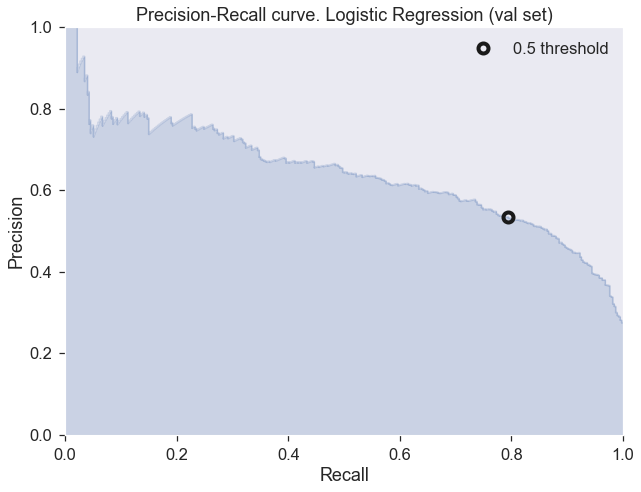

In [42]:
clf_pred_proba = pipe_lr.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, clf_pred_proba)

mark = np.argwhere(thresholds == min(thresholds, key=lambda x:abs(x-0.5)))
plt.figure(figsize=(10,7.5))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.plot(recall[mark], precision[mark], 'o', markersize=10,label="0.5 threshold", fillstyle="none", c="k", mew=4)
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.title('Precision-Recall curve. Logistic Regression (val set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0]); plt.legend(loc=1);

One other way to visualize the data is to use the x-axis as the threshold, and plot the precision and recall:

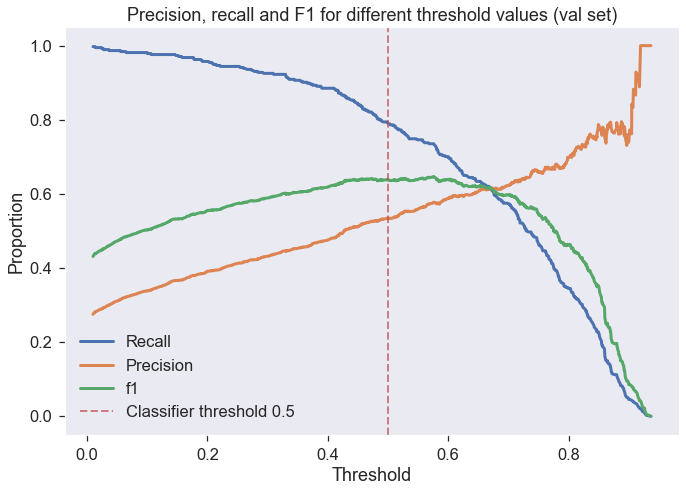

In [43]:
# Logistic Regression Precision, recall and F1 for different threshold values.
precision, recall, thresholds = precision_recall_curve(y_val, clf_pred_proba)
plt.figure(figsize=(11,7.5))
plt.plot(thresholds, recall[1:], label="Recall",linewidth=3)
plt.plot(thresholds, precision[1:], label="Precision",linewidth=3);
plt.plot(thresholds, (2 * (precision[1:] * recall[1:]) / (precision[1:] + recall[1:])), label="f1",linewidth=3);
plt.title('Precision, recall and F1 for different threshold values (val set)');
plt.xlabel('Threshold');plt.ylabel('Proportion')
plt.axvline(x=0.5,color='r', lw=2, linestyle='--', alpha=0.7, label='Classifier threshold 0.5');
plt.legend();

<b>From the chart above and as far as business objectives are concerned, <br>we can adjust our model classification threshold (decision threshold) to maximize the F1-Score (weighted average of Precision and Recall) in order to achieve higher recall rate, with the cost of higher false positive.
The main assumptions here are that acquiring a new customer is between five and 25 times more expensive than retaining an existing one,<br>
and increasing customer retention rates, even with a small portion, can significantly increase company profits</b>

In [44]:
f1 = (2 * (precision[1:] * recall[1:]) / (precision[1:] + recall[1:]))
adjusted_threshold = thresholds[np.argmax(f1)].round(3)
print(f'Currently F1 score: {f1_score(y_val, clf_pred_val).round(3)}')
print(f'Max F1 score: {np.max(f1).round(3)}')
print(f'New adjusted classifier threshold: {adjusted_threshold}')

Currently F1 score: 0.638
Max F1 score: 0.647
New adjusted classifier threshold: 0.576


<b>Now we will adjust the classifier to the New adjusted classifier threshold, and finaly test on our the test-set(unseen data).</b>

Accuracy =  0.779
Precision =  0.568
Recall =  0.706
F1 Score =  0.629
Cohen kappa =  0.475


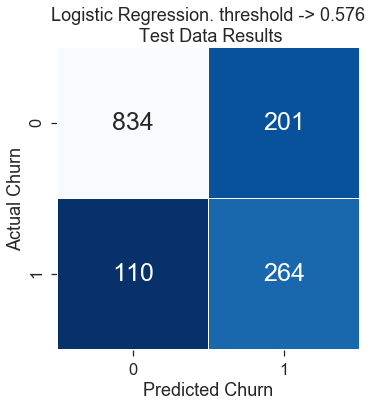

In [45]:
lr_clf_decision_thr = (pipe_lr.predict_proba(X_test)[:,1] > adjusted_threshold)
cm = confusion_matrix(y_test, lr_clf_decision_thr)
plt.subplots(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,cmap = 'Blues_r', cbar=False, annot_kws={"fontsize":25});
plt.title(f'Logistic Regression. threshold -> {adjusted_threshold}\n Test Data Results')
plt.ylabel('Actual Churn');plt.xlabel('Predicted Churn');plt.tight_layout();
report(y_test, lr_clf_decision_thr)

<b> Decile analysis & Lift</b>

,min_prob,max_prob,#customers,churn,%d_churn_rate,%g_churn_rate,%base_rate,lift,d_churn_rate
Decile,,,,,,,,,
1,0.85,0.94,122,99,0.81,0.26,0.265,3.06,0.81
2,0.74,0.84,149,93,0.62,0.25,0.265,2.34,0.62
3,0.63,0.73,142,55,0.39,0.15,0.265,1.47,0.39
4,0.49,0.62,144,43,0.30,0.11,0.265,1.13,0.30
5,0.38,0.48,135,37,0.27,0.10,0.265,1.02,0.27
6,0.25,0.37,152,24,0.16,0.06,0.265,0.60,0.16
7,0.15,0.24,142,10,0.07,0.03,0.265,0.26,0.07
8,0.08,0.14,133,9,0.07,0.02,0.265,0.26,0.07
9,0.04,0.07,140,3,0.02,0.01,0.265,0.08,0.02


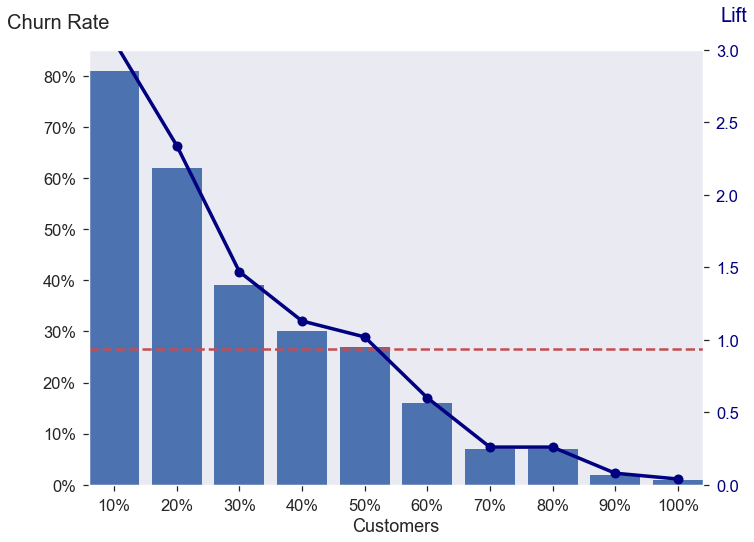

In [48]:
# divides a data series into 10 parts, and group based on the predicted churn probability (value between 0.0 and 1.0).
# in ascending order, that first decile contain highest probability score, and then calculate the true churn rate per group.

lift = pd.DataFrame({'Churn':y_test,
                     'Pred':pipe_lr.predict_proba(X_test)[:,1].round(2)})
grouped = lift.groupby(pd.qcut(lift['Pred'],10,labels=False)+1)
lift_df = pd.DataFrame()
lift_df['min_prob'] = grouped.min()['Pred']
lift_df['max_prob'] = grouped.max()['Pred']
lift_df['#customers'] = grouped.size()
lift_df['churn'] = grouped.sum()['Churn']
lift_df['%d_churn_rate'] = round(grouped.sum()['Churn'] / grouped.size(),2)
lift_df['%g_churn_rate'] = round(lift_df['churn']/y_test.sum(),2)#.apply('{:.0%}'.format)
lift_df['%base_rate'] = round(y_test.mean(),3)
lift_df['lift'] = round(lift_df['%d_churn_rate'] / lift_df['%base_rate'],2)
lift_df = lift_df.sort_values(by="min_prob", ascending=False)
lift_df['d_churn_rate'] = lift_df['%d_churn_rate']#.apply('{:.0%}'.format)
lift_df.index = range(1,11)
lift_df.index.rename('Decile', inplace=True)
fig, ax = plt.subplots(figsize=(11,8))
plt.bar(lift_df.index,lift_df['%d_churn_rate']);
plt.xlabel('Customers'); plt.ylabel('Churn Rate');plt.xticks(lift_df.index)
ax.set_ylabel('Churn Rate', fontsize=16,size=20, rotation=360, labelpad=35);
ax.yaxis.set_label_coords(-0.05,1.04)
ax.grid(False)
plt.axhline(lift_df['%base_rate'].mean(), color='r', linestyle='--', lw=2.5);
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);
ax2 = ax.twinx()
plt.plot(lift_df.index,lift_df['lift'], lw=3.5, color='navy', marker='.', markersize=20)
plt.margins(0,0);ax2.grid(False); plt.ylim(0,3);plt.ylabel('Lift')
plt.gca().set_xticklabels(['{:.0f}%'.format(x*10) for x in plt.gca().get_xticks()]);
plt.yticks(color='navy')
ax2.set_ylabel('Lift', fontsize=16, color='navy', size=20, rotation=360, labelpad=35);
ax2.yaxis.set_label_coords(+1.05,1.1)
lift_df

If we only target 10% of the customers in the first group (that has the higher probability of 0.77	to 0.90), we can expect to catch nearly three times more churning customers than we would by targeting the same number of people randomly. The churn customers in the first group account for 26% of all churn customers.

<b><u>Summary</u><b>

<b>The exploratory data analysis provided us with business understanding what features are related to customer's churn.<br>This can provide actionable insights that can help to make product, pricing and marketing decisions more effective.<br>
The company for example can re-price or stop providing fiber optics internet service, as well as lower monthly charges for new customers.<br>
As, for the models, the company can implement one or multiple churn prediction models (Ensemble) ,<br>and then combine them to increase customer retention for more profitability results.</b>